https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/

# **Auto Regression Implementation**
*This notebook processes data provided by the [IBM Call for Code Wildfire Challenge](https://community.ibm.com/community/user/datascience/blogs/susan-malaika/2020/11/10/call-for-code-spot-challenge-for-wildfires). The unpreprocessed data is available [on GitHub](https://github.com/Call-for-Code/Spot-Challenge-Wildfires).*

The notebook consists of the following process steps:

*   loading preprocessed data and weather forecast
*   split data into training, validation and testing data
*   generate predictions on validation and testing data
*   plot result

In [ ]:
!pip install --upgrade statsmodels

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from google.colab import drive

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['axes.grid'] = False

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

     |████████████████████████████████| 9.5 MB 8.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Mounted at /content/drive


*   loading preprocessed data and weather forecast

In [ ]:
forecasts_df = pd.read_csv('Cleansed_Forecasts.csv')
df = pd.read_csv('Cleansed_Data.csv')

forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'])
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

*   generate predictions on validation data

In [ ]:
result_val = pd.DataFrame(columns=['Date', 'Region', 'PREDICTIONS', 'ACTUAL'])

for region in ['NSW', 'QL', 'TA', 'VI', 'SA', 'WA', 'NT']:
  series = df[['Date','Estimated_fire_area']][df['Region'] == region].set_index(['Date'],inplace=False)
  # split dataset
  X = series.values
  size = int(len(X)-100)
  train, test = X[0:size], X[size:-15]

  # train autoregression
  model = AutoReg(train, lags=8, seasonal=False, trend='c', old_names=True)
  model_fit = model.fit()
  coef = model_fit.params

  # walk forward over time steps in test
  history = [train[i] for i in range(len(train))]
  predictions = list()
  for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

  region_result = pd.DataFrame(predictions, columns=['PREDICTIONS'])
  region_result['ACTUAL'] = test
  region_result['Region'] = region
  region_result['DIFFERENCE']=region_result.PREDICTIONS - region_result.ACTUAL
  region_result['Date'] = pd.date_range(start='24/10/2020', end='16/1/2021')
  
  result_val = pd.concat([result_val,region_result])
  rmse = math.sqrt(mean_squared_error(test, predictions))
  print('Test RMSE: %.3f' % rmse)
  # plot
  plt.plot(test)
  plt.plot(predictions, color='red')
  #plt.show()

result_val

*   generate predictions on test data

In [ ]:
result_df = pd.DataFrame(columns=['Date', 'Region', 'PREDICTIONS', 'ACTUAL'])

for region in ['NSW', 'QL', 'TA', 'VI', 'SA', 'WA', 'NT']:
  series = df[['Date','Estimated_fire_area']][df['Region'] == region].set_index(['Date'],inplace=False)
  # split dataset
  X = series.values
  size = int(len(X)-15)
  train, test = X[0:size], X[size:]
  
  # train autoregression
  model = AutoReg(train, lags=8, seasonal=False, trend='c', old_names=True)
  model_fit = model.fit()
  coef = model_fit.params

  # walk forward over time steps in test
  history = [train[i] for i in range(len(train))]
  predictions = list()
  for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

  region_result = pd.DataFrame(predictions, columns=['PREDICTIONS'])
  region_result['ACTUAL'] = test
  region_result['Region'] = region
  region_result['DIFFERENCE']=region_result.PREDICTIONS - region_result.ACTUAL
  #region_result['ABS_DIFFERENCE']=abs(region_result.DIFFERENCE)
  region_result['Date'] = pd.date_range(start='17/1/2021', end='31/1/2021')
  
  result_df = pd.concat([result_df,region_result])
  rmse = math.sqrt(mean_squared_error(test, predictions))
  print('Test RMSE: %.3f' % rmse)
  # plot
  plt.plot(test)
  plt.plot(predictions, color='red')
  #plt.show()

In [ ]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_log_error

def get_prediction_results(df):
  print('ACCURACY RESULTS')
  print('Root Mean Squared Error:',round(math.sqrt(mean_squared_error(np.asarray(df.ACTUAL), np.asarray(df.PREDICTIONS), squared=False)),2))
  #print('R2 Score:',round(r2_score(np.asarray(df.ACTUAL), np.asarray(df.PREDICTIONS)),2))

  print(df.head(5))
  print('...')
  print(df.tail(5))
  print('_______________________________')
  return df

val_result = get_prediction_results(result_val)
test_result = get_prediction_results(result_df)

ACCURACY RESULTS
Root Mean Squared Error: 6.56
        Date Region  PREDICTIONS  ACTUAL  DIFFERENCE
0 2020-10-24    NSW     4.480667    3.60    0.880667
1 2020-10-25    NSW     6.187655    3.00    3.187655
2 2020-10-26    NSW     6.774046    0.00    6.774046
3 2020-10-27    NSW     5.133098    1.21    3.923098
4 2020-10-28    NSW     4.989942    3.00    1.989942
...
         Date Region  PREDICTIONS  ACTUAL  DIFFERENCE
80 2021-01-12     NT    24.254422     0.0   24.254422
81 2021-01-13     NT    17.628405     0.0   17.628405
82 2021-01-14     NT    12.023402     0.0   12.023402
83 2021-01-15     NT    13.733416     0.0   13.733416
84 2021-01-16     NT    13.400174     0.0   13.400174
_______________________________
ACCURACY RESULTS
Root Mean Squared Error: 5.36
        Date Region  PREDICTIONS  ACTUAL  DIFFERENCE
0 2021-01-17    NSW    10.789361   5.000    5.789361
1 2021-01-18    NSW     9.217584   3.840    5.377584
2 2021-01-19    NSW     9.739488   6.075    3.664488
3 2021-01-20    

In [ ]:
from sklearn.model_selection import cross_validate

cv = cross_validate(model_fit, X, y, scoring=['r2', 'neg_mean_absolute_error'], n_jobs=-1, verbose=0)
cvp = cross_val_predict(model_fit, X, y, n_jobs=-1, verbose=0

In [ ]:
val_result.reset_index(inplace=True)

for region in ['NSW', 'VI', 'TA', 'SA', 'NT', 'QL', 'WA']:
  df_reg = val_result[val_result['Region'] == region].set_index(['Date'],inplace=False)
  print('Region:', region ,', Root Mean Squared Error:',round(math.sqrt(mean_squared_error(np.asarray(df_reg.ACTUAL), np.asarray(df_reg.PREDICTIONS), squared=False)),2))

Region: NSW , Root Mean Squared Error: 2.8
Region: VI , Root Mean Squared Error: 2.68
Region: TA , Root Mean Squared Error: 1.4
Region: SA , Root Mean Squared Error: 3.18
Region: NT , Root Mean Squared Error: 6.18
Region: QL , Root Mean Squared Error: 9.09
Region: WA , Root Mean Squared Error: 8.16


*   plot result


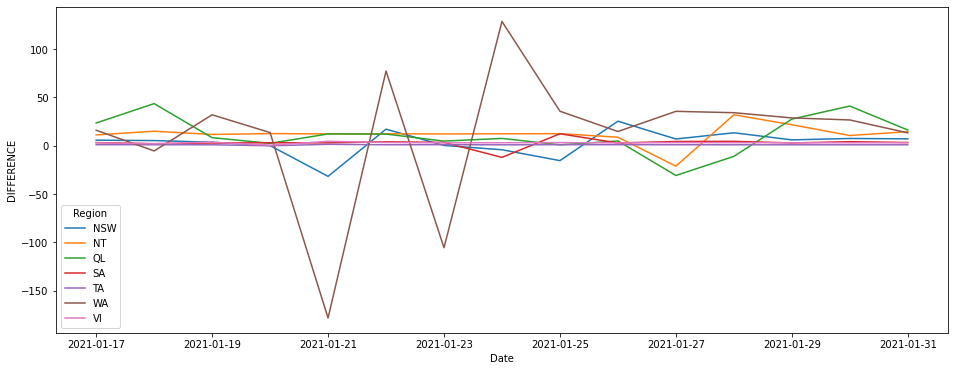

In [ ]:
plt.figure(figsize=(16, 6))

result_df['DIFFERENCE'] = result_df.PREDICTIONS - result_df.ACTUAL
g = sns.lineplot(x="Date", y="DIFFERENCE", hue='Region', data=result_df, hue_order=['NSW', 'NT', 'QL', 'SA', 'TA', 'WA', 'VI'])